# Final Exam

# Question 1 

## Preprocessing

### Data Exploration 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set_theme(style='white', palette='colorblind', font_scale=1.4)

from matplotlib import pyplot as plt

In [2]:
file = './data/Q1_X.csv'
Q1_X = pd.read_csv(file, index_col=None)
Q1_X.shape

(560, 974)

n < p, which type do we have in it ? Do we have null values in it ?

In [3]:
Q1_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Columns: 974 entries, X1 to X974
dtypes: float64(952), int64(22)
memory usage: 4.2 MB


Only numerical values, greate !

In [4]:
# sum on each feature then on every result
Q1_X.isnull().sum().sum()

0

great ^^ nothing

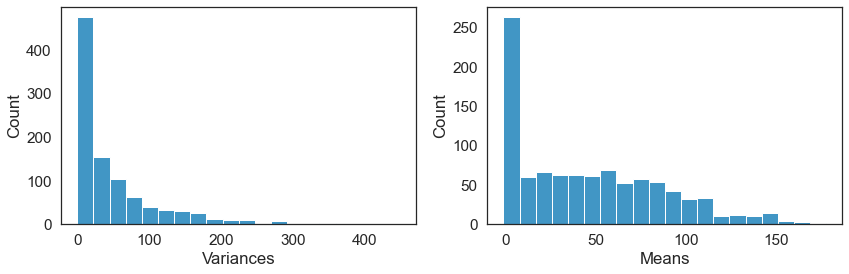

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
sns.histplot(ax = axs[0], data=Q1_X.var(), bins=20)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=Q1_X.mean(), bins=20)
axs[1].set_xlabel('Means')
plt.show()

Variety of mean values & variance values 
We see a high number of low variance features -> lets see if there is some zero variance features and remove them since it will allow us to standardize the features 

In [6]:
feature_var = Q1_X.var()
feature_var[feature_var == 0].keys().shape

(22,)

Not that much but lets espace them

In [7]:
non_zero_var_features = feature_var[feature_var != 0].keys()
Q1_X_new = Q1_X[non_zero_var_features]

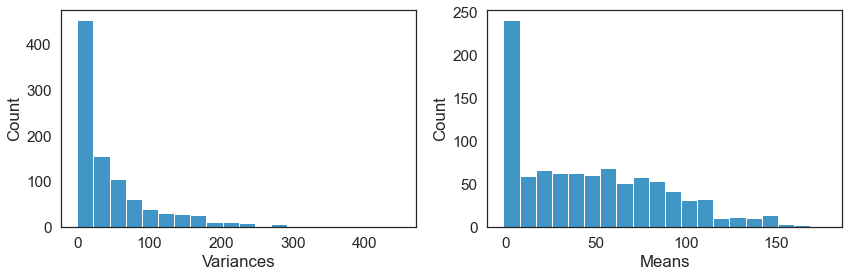

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
sns.histplot(ax = axs[0], data=Q1_X_new.var(), bins=20)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=Q1_X_new.mean(), bins=20)
axs[1].set_xlabel('Means')
plt.show()

Obviously it doesnt change much. Means and Variances still vary substantially, Standardize the data will help a lot for clustering since it keeps the overall shape of the data while putting every feature at the same scale 

Even if we are in a n < p situation, it is not necessary to perform variance filtering (losing sometimes meaningful data based of crud method) or randomized SVD because the number of features is highly manageable (p=974), it is not a n << p situation 

Still we will perform PCA to reduce the number of dimension, thus we can try to see if we can distinguish groups of data

### Dimension Reduction

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(Q1_X_new.to_numpy())

pca = PCA() 
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)

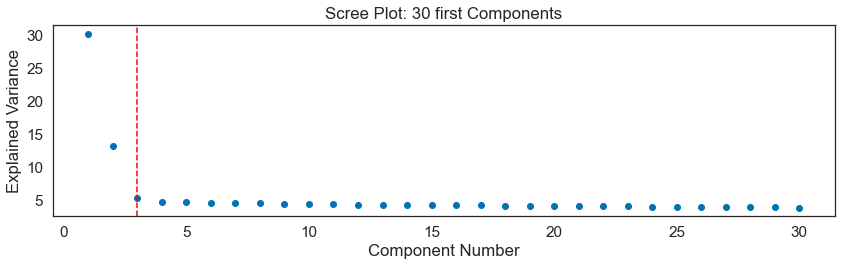

In [11]:
plt.figure(figsize=(12, 4))
plt.title('Scree Plot: 30 first Components')
plt.scatter(range(1, 31), pca.explained_variance_[:30])
plt.axvline(3, color='red', linestyle='dashed')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.tight_layout()
plt.show()

Clear Elbow at 3 principal components. To be sure to not miss any essential information, lets take 5

In [12]:
X_pca_selected = data_pca[:, :5]

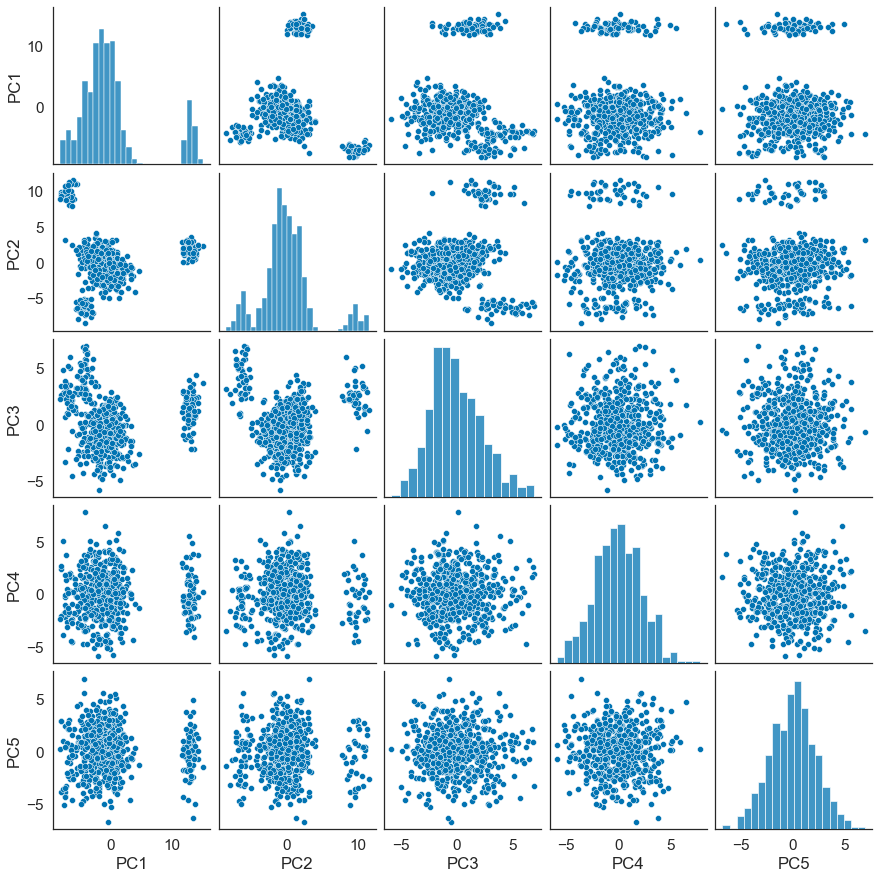

In [13]:
sns.pairplot(pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]))
plt.show()

We can see patterns both in the histograms and in the scatter plots, clearly suggesting that there should be clusters in the data.  
Also, we can notice that there's no additionnal value to add PC4 and PC5 as they look very gaussian, including them will only add noise to the model.

In [14]:
X_pca_selected = X_pca_selected[:, :3]

We can distinguish 3 to 4 groups, which do look convex: it is reasonable to except convex cluster algorithms to work well.

Groups of data are quite spheric if we look from the perspective of PC1 vs PC2, but dont seems to be the same size/have the same nb of points (3 litte groups & 1 big in the center).   
However, **k-means** can still perform well on this problem since the nb of points between two group doesnt seems to be that large.  
But as we can see from the perspective of PC3, the groups are more elongated. We could apply **GMM** to handle elongated groups (which is model based clustering so there no problem to perform it on Principal components).  
No use of density based clustering since we dont have any non convex shapes.  
Maybe use Hierarchical Clusturing to double check since it is a deterministic algorithm (Ward -> convex shapes).

## Model Selection

### Choice of internal clustering validation measures  

![img](internal_clustering_validation_measures.png)

**Reference**: *Understanding of Internal Clustering Validation Measures, 2010 IEEE International Conference on Data Mining*

#### Silhouette width index 

Contrasts the average distance to elements in the same cluster with the average distance to elements in other clusters. Objects with a high silhouette value are considered well clustered, objects with a low value may be outliers.  
It is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.  
It is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.  
However, It is generally higher for convex clusters than other concepts of clusters (density based clusters, e.g. DBSCAN).  
Quadratic Complexity O(n²).  
  
We are looking for a **Maximum**.

#### Davies-Bouldin index 

Measures the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.  
Since algorithms that produce clusters with low intra-cluster distances (high intra-cluster similarity) and high inter-cluster distances (low inter-cluster similarity) will have a low Davies–Bouldin index, the clustering algorithm that produces a collection of clusters with the smallest Davies–Bouldin index is considered the best algorithm based on this criterion.   
However, the usage of centroid distance limits the distance metric to Euclidean space and this index is generally higher for convex clusters than other concepts of clusters (density based clusters, e.g. DBSCAN). 
Faster than Silhouette index.  

We are looking for a **Minimum**.

#### Calinski-Harabasz Index

It is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). The score is higher when clusters are dense and well separated.  
The higher the score, the better the performances (relating to a standard concept of a cluster). 
However, it is generally higher for convex clusters than other concepts of clusters (density based clusters, e.g. DBSCAN).  
Fast to compute.  

We ar looking for a **Maximum**.

#### Within Cluster Scatter (for Kmeans)

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion. Inertia can be recognized as a measure of how internally coherent clusters are.  
However, Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes. Inertia is not a normalized metric: we just know that lower values are better and zero is optimal.But in very high-dimensional spaces, Euclidean distances tend to become inflated (“curse of dimensionality”).

We are looking for an **Elbow**.

#### Bayesian information criterion (for GMM)

The GMM algorithm aims to maximize the likelihood between the data and a precise number of gaussian components. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC attempt to resolve this problem by introducing a penalty term for the number of parameters and the number of data points in the model.  
It is used as a criterion of model selection, the model with the lowest BIC is preferred.   
  
We are looking for an **Elbow** which sould be a **Minimum**

### KMeans

Since k-means depends on its initial values and perform in a greedy fashion, it is not guaranteed that it will converge to a global optimum. To avoid to get stuck in a local minimum, k-means has to run repeatedly. We will do so and only keep the best runs that achieve the minimum within cluster scatter, criterion that k-means tries to minimize. That way, the solution has a better chance to be the global minimum.

Also, we will reapeat the process multiple times so that we will can visualise measure the uncertainty of the results

In [15]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#### Setup

We will scan across 2 to 10 clusters.  
For each cluster count, we will perform 1000 iterations : 50 inner kmeans iterations (saving the best result) & 20 outer iterations so we can monitor kmeans variability.   
We will use *k-means++*, which initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. 

In [16]:
init      = 'k-means++'
tolerance = 0.001 # reducing this will speed up convergence but reduce precision

clusters  = np.arange(2, 11)
n_iter    = 20
n_init    = 50 

Working KMeans with 2  clusters ....
Working KMeans with 3  clusters ....
Working KMeans with 4  clusters ....
Working KMeans with 5  clusters ....
Working KMeans with 6  clusters ....
Working KMeans with 7  clusters ....
Working KMeans with 8  clusters ....
Working KMeans with 9  clusters ....
Working KMeans with 10  clusters ....


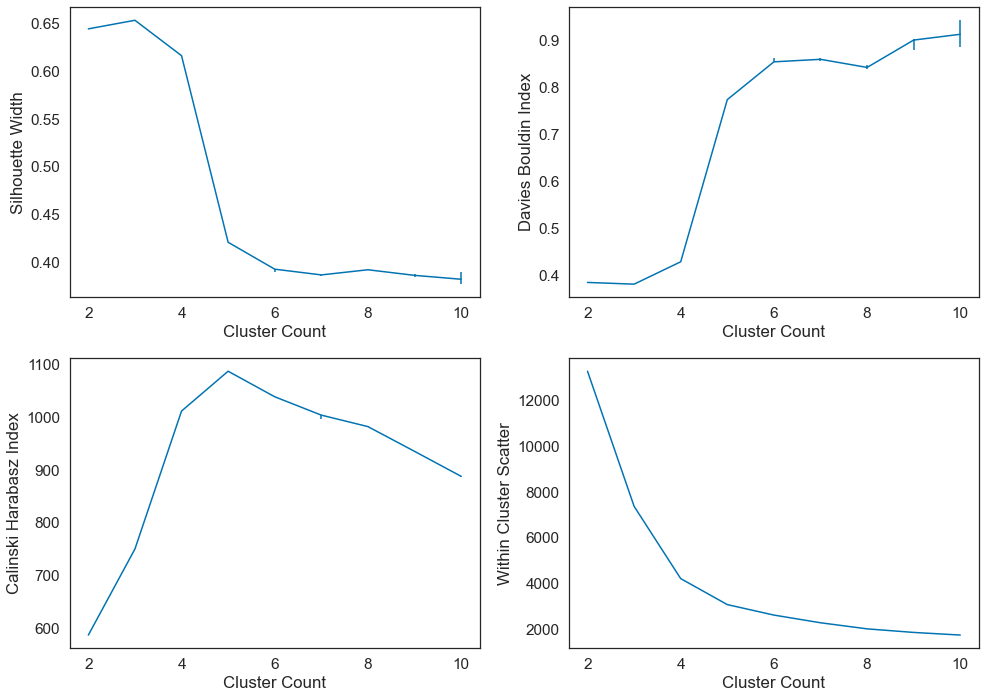

In [17]:
silhouette_score_kmeans        = np.zeros((len(clusters), n_iter), dtype=float) 
davies_bouldin_score_kmeans    = np.zeros((len(clusters), n_iter), dtype=float)
calinski_harabasz_score_kmeans = np.zeros((len(clusters), n_iter), dtype=float)
within_cluster_scatter_kmeans  = np.zeros((len(clusters), n_iter), dtype=float)

for i, nb_of_clusters in enumerate(clusters) :
    
    print(f"Working KMeans with {nb_of_clusters}  clusters ....")
    
    for j in range(n_iter) : 
        kmeans = KMeans(n_clusters=nb_of_clusters, n_init=n_init, init=init, tol=tolerance)
        kmeans.fit(X_pca_selected)
        
        silhouette_score_kmeans[i, j]        = silhouette_score(X_pca_selected, kmeans.labels_)
        davies_bouldin_score_kmeans[i, j]    = davies_bouldin_score(X_pca_selected, kmeans.labels_)
        calinski_harabasz_score_kmeans[i, j] = calinski_harabasz_score(X_pca_selected, kmeans.labels_)
        within_cluster_scatter_kmeans[i, j]  = kmeans.inertia_
        

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].errorbar(
    clusters, 
    np.median(silhouette_score_kmeans, axis=1), 
    [
        np.median(silhouette_score_kmeans, axis=1) - np.min(silhouette_score_kmeans, axis=1), 
        np.max(silhouette_score_kmeans, axis=1) - np.median(silhouette_score_kmeans, axis=1)
    ]
)
axs[0, 0].set_xlabel("Cluster Count")
axs[0, 0].set_ylabel("Silhouette Width")

axs[0, 1].errorbar(
    clusters, 
    np.median(davies_bouldin_score_kmeans, axis=1), 
    [
        np.median(davies_bouldin_score_kmeans, axis=1) - np.min(davies_bouldin_score_kmeans, axis=1), 
        np.max(davies_bouldin_score_kmeans, axis=1) - np.median(davies_bouldin_score_kmeans, axis=1)
    ]
)
axs[0, 1].set_xlabel("Cluster Count")
axs[0, 1].set_ylabel("Davies Bouldin Index")

axs[1, 0].errorbar(
    clusters, 
    np.median(calinski_harabasz_score_kmeans, axis=1), 
    [
        np.median(calinski_harabasz_score_kmeans, axis=1) - np.min(calinski_harabasz_score_kmeans, axis=1), 
        np.max(calinski_harabasz_score_kmeans, axis=1) - np.median(calinski_harabasz_score_kmeans, axis=1)
    ]
)
axs[1, 0].set_xlabel("Cluster Count")
axs[1, 0].set_ylabel("Calinski Harabasz Index")

axs[1, 1].errorbar(
    clusters, 
    np.median(within_cluster_scatter_kmeans, axis=1), 
    [
        np.median(within_cluster_scatter_kmeans, axis=1) - np.min(within_cluster_scatter_kmeans, axis=1), 
        np.max(within_cluster_scatter_kmeans, axis=1) - np.median(within_cluster_scatter_kmeans, axis=1)
    ]
)
axs[1, 1].set_xlabel("Cluster Count")
axs[1, 1].set_ylabel("Within Cluster Scatter")

fig.tight_layout()
plt.show()

The solid lines show the median value of the indices across the number of outer runs. The bars show the range of values achieved for that cluster count.

We can clearly see instabilities above 6 clusters according to the Silhouette width and Davies-Bouldin Index. Also these two indexes clearly indicate that 3 clusters is the best count if we focus on the *low intra-cluster distances and high inter-cluster distances* criterion for clustering. 2 and 4 clusters have in both cases close score to the optimum so we can argue that they also are good choices.   
The within Cluster Scatter score decreases with the cluster counts and the higher the cluster count is the slower the decrease. We can argue that 3 or 4 are good cluster counts since each time we have a significative decrease (an elbow).  
However, the Calinski Harabasz Index indicate that 5 is the best cluster count based on between VS inner cluster dispersion, but 4 and 6 have similar values.

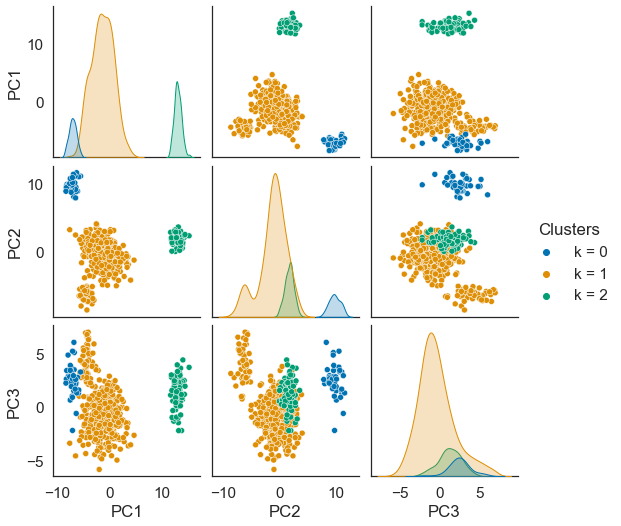

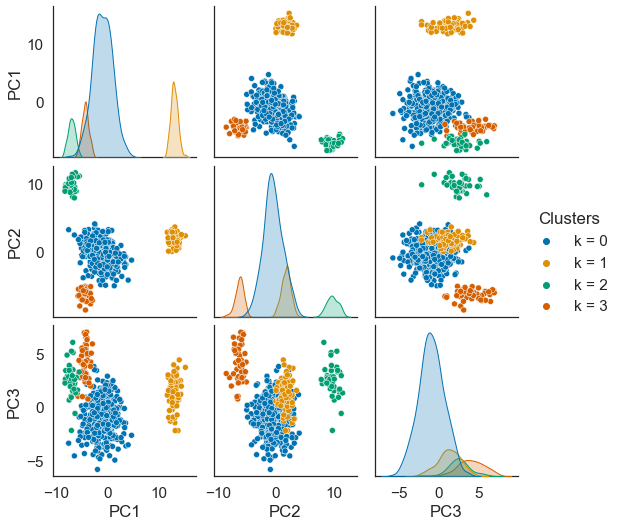

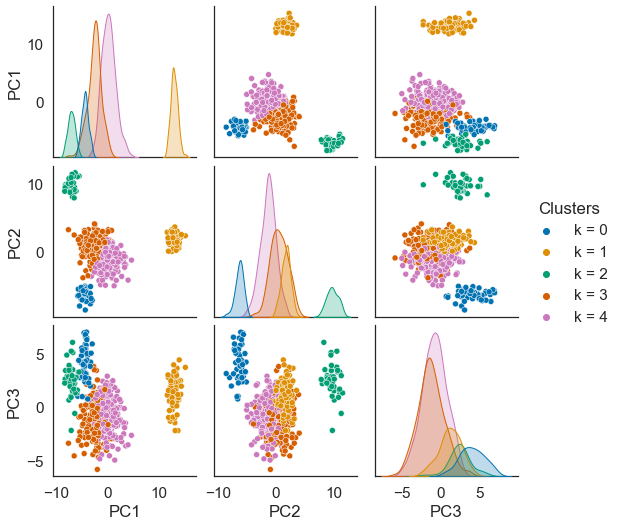

In [18]:
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in KMeans(n_clusters=3, n_init=n_init, init=init, tol=tolerance).fit(X_pca_selected).labels_
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(3)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in KMeans(n_clusters=4, n_init=n_init, init=init, tol=tolerance).fit(X_pca_selected).labels_
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(4)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)

sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in KMeans(n_clusters=5, n_init=n_init, init=init, tol=tolerance).fit(X_pca_selected).labels_
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(5)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

It makes a lot more sens with 4 clusters, we can see well separated groups of data.

### Gaussian Mixture Model

As k-means, Gaussian Mixture depends on its initial values, so that it is not guaranteed that it will converge to a global optimum. To avoid getting stuck in a local minimum, it can be initialized with k-means. It generally increases cluster selection.  
Then, the algorithm run and will try to maximize the likelihood of the data given the initial assignments. Repeating this process is guaranteed to always converge to a local optimum.

In [19]:
from sklearn.mixture import GaussianMixture 

#### Setup

We will scan across 2 to 10 clusters.  
For each cluster count, we will perform 1000 iterations : 50 inner gmm iterations (saving the best result) & 20 outer iterations so we can monitor gmm variability.  
We will allow each component to have its own general covariance matrix.  
We will initialize Gaussian Mixture with k-means, thus we can have better results.  

In [20]:
covariance_type = 'full'
tolerance = 0.001 # reducing this will speed up convergence but reduce precision
init_params = 'kmeans'

clusters = np.arange(2, 11)
n_iter   = 20
n_init   = 50

Working GMM with 2  clusters ....
Working GMM with 3  clusters ....
Working GMM with 4  clusters ....
Working GMM with 5  clusters ....
Working GMM with 6  clusters ....
Working GMM with 7  clusters ....
Working GMM with 8  clusters ....
Working GMM with 9  clusters ....
Working GMM with 10  clusters ....


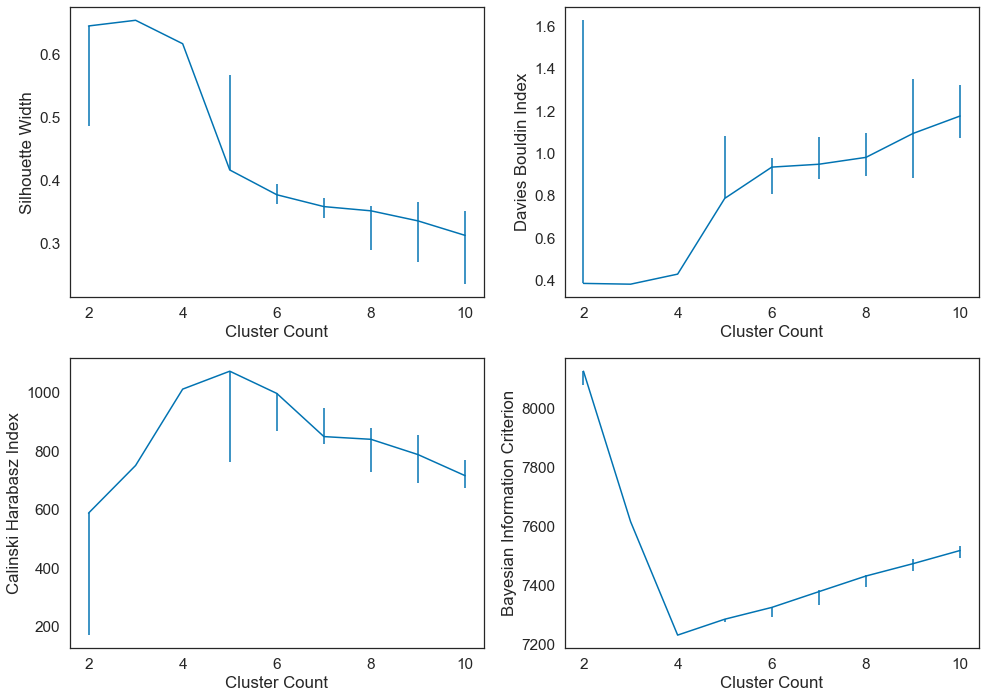

In [21]:
silhouette_score_gmm           = np.zeros((len(clusters), n_iter), dtype=float) 
davies_bouldin_score_gmm       = np.zeros((len(clusters), n_iter), dtype=float)
calinski_harabasz_score_gmm    = np.zeros((len(clusters), n_iter), dtype=float)
bayesian_information_criterion = np.zeros((len(clusters), n_iter), dtype=float)


for i, nb_of_clusters in enumerate(clusters) : 
    print(f"Working GMM with {nb_of_clusters}  clusters ....")
    for j in range(n_iter) : 
        gmm = GaussianMixture(
            n_components=nb_of_clusters, n_init=n_init, init_params=init_params, 
            covariance_type=covariance_type, tol=tolerance
        )
        gmm.fit(X_pca_selected)
        
        silhouette_score_gmm[i, j]           = silhouette_score(X_pca_selected, gmm.predict(X_pca_selected))
        davies_bouldin_score_gmm[i, j]       = davies_bouldin_score(X_pca_selected, gmm.predict(X_pca_selected))
        calinski_harabasz_score_gmm[i, j]    = calinski_harabasz_score(X_pca_selected, gmm.predict(X_pca_selected))
        bayesian_information_criterion[i, j] = gmm.bic(X_pca_selected)
        

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].errorbar(
    clusters, 
    np.median(silhouette_score_gmm, axis=1), 
    [
        np.median(silhouette_score_gmm, axis=1) - np.min(silhouette_score_gmm, axis=1), 
        np.max(silhouette_score_gmm, axis=1) - np.median(silhouette_score_gmm, axis=1)
    ]
)
axs[0, 0].set_xlabel("Cluster Count")
axs[0, 0].set_ylabel("Silhouette Width")

axs[0, 1].errorbar(
    clusters, 
    np.median(davies_bouldin_score_gmm, axis=1), 
    [
        np.median(davies_bouldin_score_gmm, axis=1) - np.min(davies_bouldin_score_gmm, axis=1), 
        np.max(davies_bouldin_score_gmm, axis=1) - np.median(davies_bouldin_score_gmm, axis=1)
    ]
)
axs[0, 1].set_xlabel("Cluster Count")
axs[0, 1].set_ylabel("Davies Bouldin Index")

axs[1, 0].errorbar(
    clusters, 
    np.median(calinski_harabasz_score_gmm, axis=1), 
    [
        np.median(calinski_harabasz_score_gmm, axis=1) - np.min(calinski_harabasz_score_gmm, axis=1), 
        np.max(calinski_harabasz_score_gmm, axis=1) - np.median(calinski_harabasz_score_gmm, axis=1)
    ]
)
axs[1, 0].set_xlabel("Cluster Count")
axs[1, 0].set_ylabel("Calinski Harabasz Index")

axs[1, 1].errorbar(
    clusters, 
    np.median(bayesian_information_criterion, axis=1), 
    [
        np.median(bayesian_information_criterion, axis=1) - np.min(bayesian_information_criterion, axis=1), 
        np.max(bayesian_information_criterion, axis=1) - np.median(bayesian_information_criterion, axis=1)
    ]
)
axs[1, 1].set_xlabel("Cluster Count")
axs[1, 1].set_ylabel("Bayesian Information Criterion")

fig.tight_layout()
plt.show()

The solid lines show the median value of the indices across the number of outer runs. The bars show the range of values achieved for that cluster count.

GMM leads to very unstable results in every cases except for 3 or 4 clusters. 2 is a very unstable choice and most of the times it provides a poor result compared to other choices.
The elbow on the BIC score is clearly indicating us that 4 is the optimal result for this algorithm & settings.  
Calinski Harabasz index is maximized with a 5 cluster counts (at least 50%) of the time but lead to unstable results. 4 clusters leads to a perfectly stable and very high score.
All of it is a very clear indication that if the data has a gaussian behaviour, then 4 is the best cluster count. 

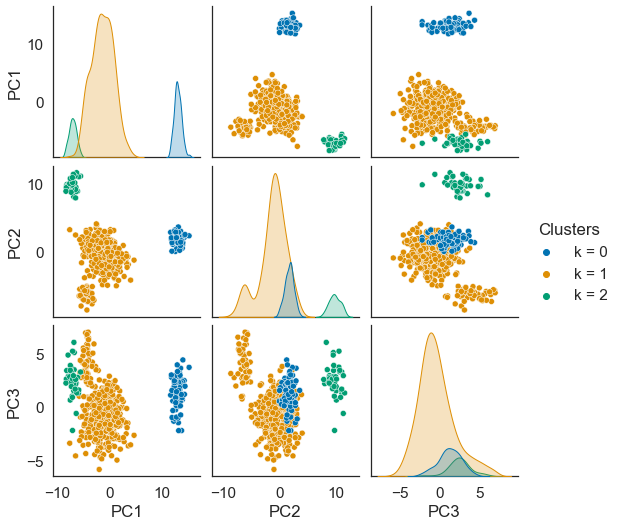

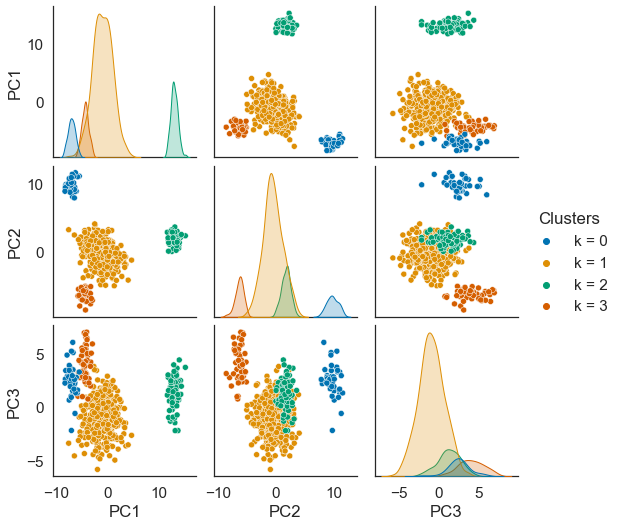

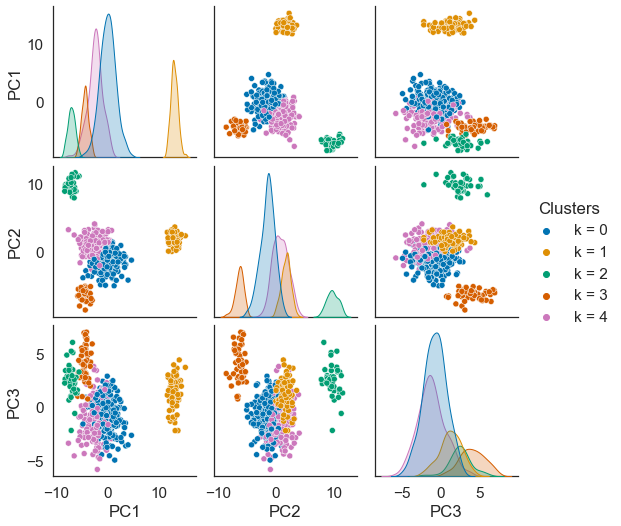

In [22]:
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in GaussianMixture(n_components=3, n_init=n_init, init_params=init_params, 
                                             tol=tolerance, covariance_type=covariance_type).fit_predict(X_pca_selected)
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(3)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in GaussianMixture(n_components=4, n_init=n_init, init_params=init_params, 
                                             tol=tolerance, covariance_type=covariance_type).fit_predict(X_pca_selected)
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(4)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l}" 
                    for l in GaussianMixture(n_components=5, n_init=n_init, init_params=init_params, 
                                             tol=tolerance, covariance_type=covariance_type).fit_predict(X_pca_selected)
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(5)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

Extremely similar to k-means results 

It is not surprising that the result is very similar since the data groups are convex and very well separated. The scores and plots are clear indications that if the data has a gaussian behavior, then 4 is the best cluster count.

### Hierarchical clustering

Let's repeat the clustering for hierarchical clustering. Given a dataset, the choice of a linkage and the choice of a metric, the clustering is effectively deterministic. This way, it is enough to compute the tree one and investigate it for different cluster counts. 

#### Linkage Selection 



* Single linkage minimizes the distance between the closest observations of pairs of clusters. It is fast and can perform well on non-globular data, but it performs poorly in the presence of noise.


* Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

* Average linkage minimizes the average of the distances between all observations of pairs of clusters.
  * Average and complete linkage perform well on cleanly separated globular clusters, but have mixed results otherwise.


* Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach. It is the most effective method for noisy data. 


We will chose **Ward's linkage** because it is the most suitable for our problem

In [23]:
from scipy.cluster.hierarchy import fcluster, ward
from scipy.spatial.distance import pdist

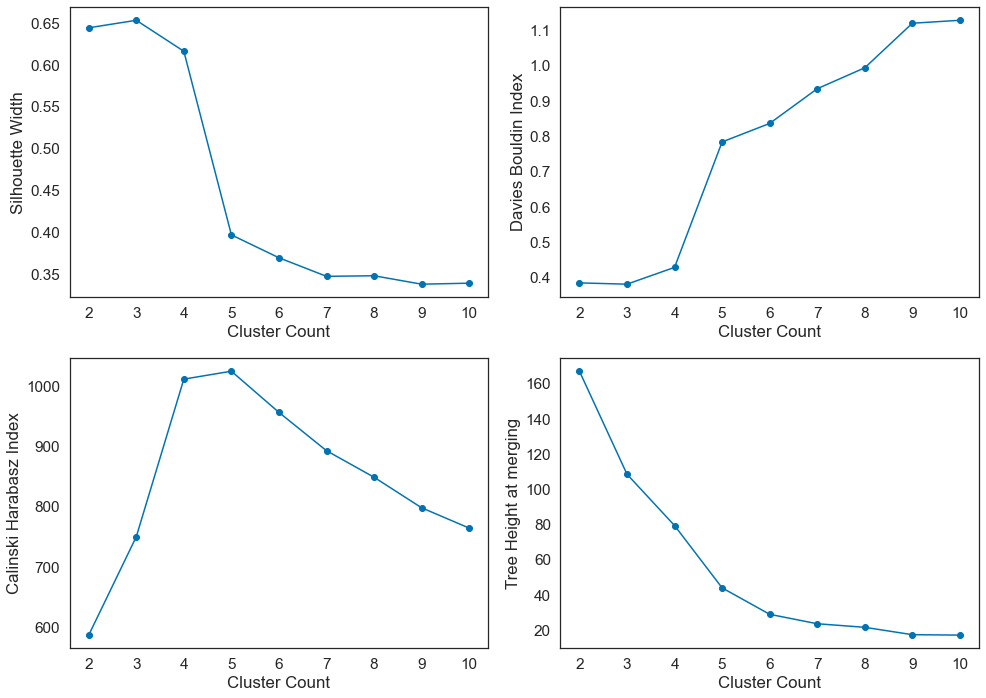

In [24]:
clusters = np.arange(2, 11)
n_points = X_pca_selected.shape[0]

D = pdist(X_pca_selected, metric='euclidean')
Z_ward = ward(D)
# hierachical clustering is performed 

silhouette_score_ward           = np.zeros((len(clusters), ), dtype=float) 
davies_bouldin_score_ward       = np.zeros((len(clusters), ), dtype=float)
calinski_harabasz_score_ward    = np.zeros((len(clusters), ), dtype=float)
ward_linkage_value              = Z_ward[n_points - max(clusters):n_points - min(clusters) +1, 2][::-1]


for i, nb_of_clusters in enumerate(clusters) : 
    
    labels = fcluster(Z_ward, t=Z_ward[n_points - 1 - nb_of_clusters, 2], criterion='distance')

    silhouette_score_ward[i]           = silhouette_score(X_pca_selected, labels)
    davies_bouldin_score_ward[i]       = davies_bouldin_score(X_pca_selected, labels)
    calinski_harabasz_score_ward[i]    = calinski_harabasz_score(X_pca_selected, labels)
    
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(clusters, silhouette_score_ward, 'o-')
axs[0, 0].set_xlabel("Cluster Count")
axs[0, 0].set_ylabel("Silhouette Width")

axs[0, 1].plot(clusters, davies_bouldin_score_ward, 'o-')
axs[0, 1].set_xlabel("Cluster Count")
axs[0, 1].set_ylabel("Davies Bouldin Index")

axs[1, 0].plot(clusters, calinski_harabasz_score_ward, 'o-')
axs[1, 0].set_xlabel("Cluster Count")
axs[1, 0].set_ylabel("Calinski Harabasz Index")

axs[1, 1].plot(clusters, ward_linkage_value, 'o-')
axs[1, 1].set_xlabel("Cluster Count")
axs[1, 1].set_ylabel("Tree Height at merging")

fig.tight_layout()
plt.show()

The ponits represent the value of the indices across the number of clusters. There no measure of incertainty hers since the algorithme is deterministic.

The tree height at merging represents the value of the linkage function when two clusters are merged together. We can see that the big jump is clearly between 1 and 2 or 3 and 4 clusters, which indicates that a good cut would be at 2 or 4 clusters.

For the other curves it is quite the same as kmeans, which was quite expected since we choose ward linkage.

In [25]:
pd.DataFrame({
    'cluster_count': np.arange(1, 8), 
    'tree_height': Z_ward[n_points - 8:, 2][::-1]
})

,cluster_count,tree_height
0,1,167.191394
1,2,108.631471
2,3,79.457513
3,4,44.038349
4,5,29.006873
5,6,23.644743
6,7,21.611840


To create cluster label, we will need to decide on a cut height t. Cutting at t = 110 seems reasonable if we want 2 clusters and t = 50 seems reasonable if we want 4 clusters.  

In [26]:
labels_t_110 = fcluster(Z_ward, t=110, criterion='distance')
labels_t_50 = fcluster(Z_ward, t=50, criterion='distance')

In [27]:
pd.Series(labels_t_110).value_counts()

2    490
1     70
dtype: int64

We can notice a huge difference between cluster sizes

In [28]:
pd.Series(labels_t_50).value_counts()

4    400
1     70
3     50
2     40
dtype: int64

Also a big difference between cluster sizes but it macthes the pattern of what we observed in the pair plots (1 big group and 3 little ones)

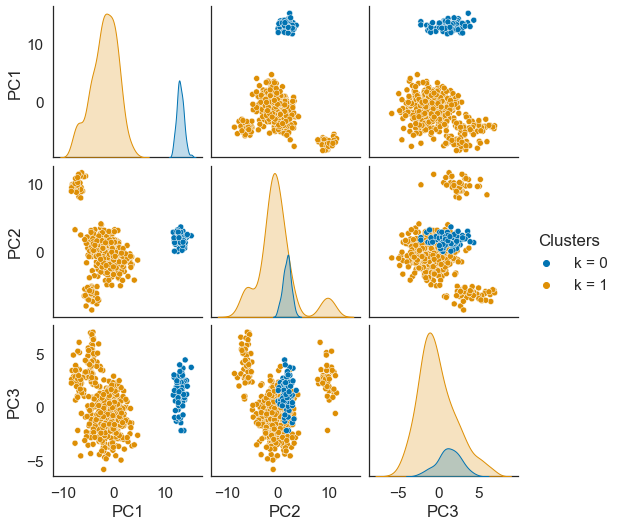

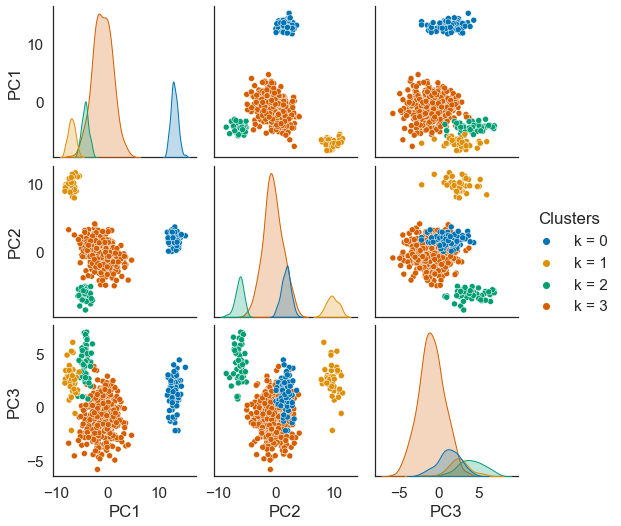

In [29]:
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l - 1}" 
                    for l in fcluster(Z_ward, t=110, criterion='distance')
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(2)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l - 1}" 
                    for l in fcluster(Z_ward, t=50, criterion='distance')
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(4)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

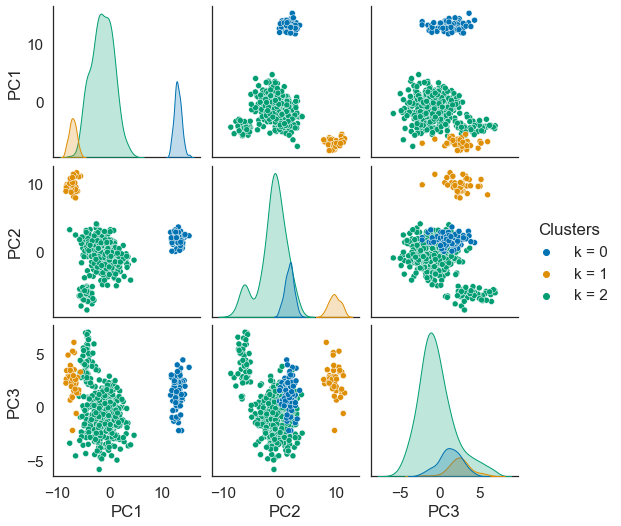

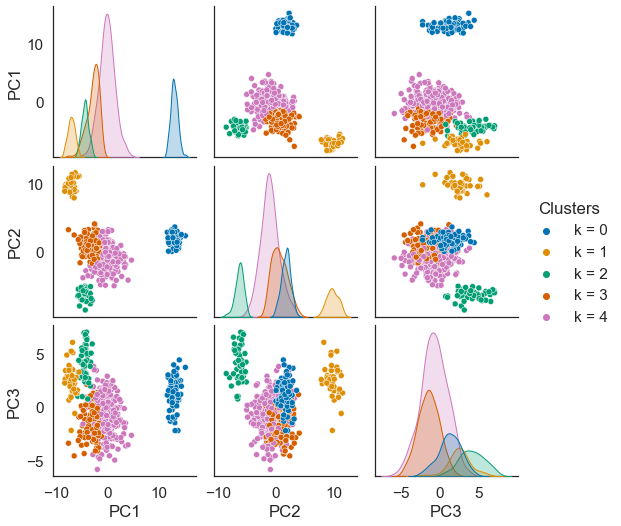

In [30]:
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l - 1}" 
                    for l in fcluster(Z_ward, t=80, criterion='distance')
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(3)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()
sns.pairplot(
    pd.concat(
        [
            pd.DataFrame(X_pca_selected, columns=[f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]), 
            pd.DataFrame({
                'Clusters': [
                    f"k = {l - 1}" 
                    for l in fcluster(Z_ward, t=30, criterion='distance')
                ]
            })
        ], 
        axis = 1
    ),
    hue = "Clusters", 
    hue_order = [f"k = {l}" for l in range(5)],
    vars = [f"PC{i}" for i in range(1, X_pca_selected.shape[1] + 1)]
)
plt.show()

Once again, 4 clusters is the choice that provide the cleanest result.

## Consensus Clustering

#### Setup

In [31]:
random_state      = np.random.default_rng(12345)
subsample_repeats = 50
n_clusters        = np.arange(2, 11)
cluster_repeat    = 5

#### Storage

In [32]:
results_consensus = [
    {
        k:{'connectivity_matrices':[], 'indicator_matrices':[]} for k in n_clusters
    }
    for _ in range(cluster_repeat)
]

#### Process

The idea here is that the data is repeatedly perturbed (e.g. by taking random sub-samples of the data) and clustering with a fixed cluster count is performed on these perturbed datasets. If the clusterings are similar across perturbed datasets, it is reasonable to say that the cluster result is stable. Stability is intuitively a good property to have when clustering, since it ensures that the result you are looking at is not just a chance outcome.

In [33]:
n = X_pca_selected.shape[0]
for subsample_iteration in range(subsample_repeats):
    idx = random_state.choice(n, size=int(np.floor(0.8 * n)), replace=False)
    
    for k in n_clusters: 
        for repeat in range(cluster_repeat): 
            kmeans = KMeans(n_clusters=k, n_init=10).fit(X_pca_selected[idx,:])
            
            Cmat = np.zeros((n, n), dtype=int)
            Imat = np.zeros((n, n), dtype=int)
            
            for i, j in enumerate(idx):
                col_idx = idx[np.where(kmeans.labels_[i] == kmeans.labels_)[0]]
                Cmat[j, col_idx] = 1
                Imat[j, idx]     = 1
                
            results_consensus[repeat][k]['connectivity_matrices'].append(Cmat)
            results_consensus[repeat][k]['indicator_matrices'].append(Imat)

In [34]:
consensus_matrices = [
    {
        k: sum(res['connectivity_matrices']) / sum(res['indicator_matrices'])
        for k, res in results.items()
    }
    for results in results_consensus
]

The intuition behind the consensus matrix is that it measures how often two samples appeared in the same cluster relative to how often they appear in the same subsample. If this number is zero, then they never ended up in the same cluster, if it is 1 then they always ended up in the same cluster. Clusters would be completely stable if all entries of the consensus matrix are only 0 or 1. Often however, one observes also proportions in-between.

A measure for cluster stability can be computed on the empirical distribution function of the elements of the consensus matrix 

In [35]:
def empirical_cdf(data, x):
    n = len(data)
    ecdf = np.arange(n + 1) / n
    idx = np.searchsorted(np.sort(data), x)
    return ecdf[idx]

Ideally the line should jump up at 0 (since many entries will be zero), then stay as flat as possible and jump again close to 1 to account for the other values that should be close to one. If there are many proportions between 0 and 1 in the consensus matrix, this indicates that the clustering is not very stable.

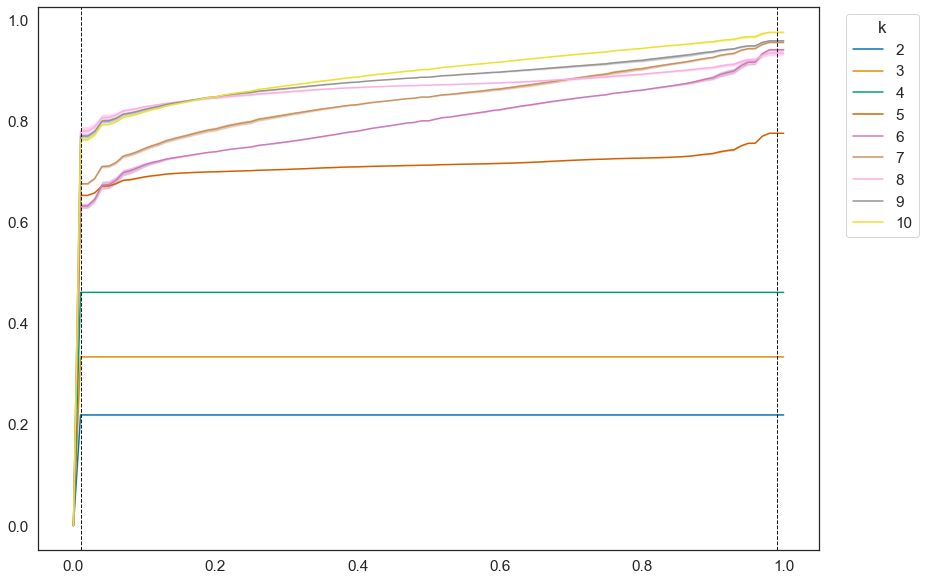

In [36]:
xs = np.arange(0, 1.01, step=0.01)
ecdf = np.zeros((len(n_clusters), cluster_repeat, len(xs)))
plt.figure(figsize=(14, 10))

for j, cms in enumerate(consensus_matrices):
    for i, (k, Cmat) in enumerate(cms.items()):
        ecdf[i, j, :] = empirical_cdf(Cmat.flatten(), xs)
        
for i, k in enumerate(n_clusters): 
    plt.fill_between(
        xs, 
        np.mean(ecdf[i, :, :], axis=0) + np.std(ecdf[i, :, :], axis=0),
        np.mean(ecdf[i, :, :], axis=0) - np.std(ecdf[i, :, :], axis=0),
        alpha=0.5
    )
    plt.plot(xs, np.mean(ecdf[i, :, :], axis=0), label=k)
    
plt.axvline(0.01, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.99, color='k', linestyle='dashed', linewidth=1)
plt.legend(title='k', loc='upper left', bbox_to_anchor=(1.025, 1))
plt.show()

Empirical distribution of flatten concessus matrices for each cluster count.

Dash lines represente the 0.01 quantile and the 0.99 quantile
There's almost no uncertainty in the consensus here which is not surprising since kmean was very consistant so far in this exercise

Here its clear that 2, 3, 4 clusters are very stable results, 5 is pretty stable, the other are a lot less stable

# Question 2

## Data Exploration

In [37]:
Q2_X1 = pd.read_csv('./data/Q2_X1.csv', index_col=None)
Q2_X2 = pd.read_csv('./data/Q2_X2.csv', index_col=None)
Q2_y  = pd.read_csv('./data/Q2_y.csv' , index_col=None)

### X1 summary 

In [38]:
Q2_X1.info(max_cols=1)
print(f"Nan values: {Q2_X1.isnull().sum().sum()}")
print(f"Constant features: {Q2_X1.var()[Q2_X1.var() == 0].keys().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Columns: 160 entries, D1 to D160
dtypes: float64(160)
memory usage: 261.4 KB
Nan values: 0
Constant features: 0


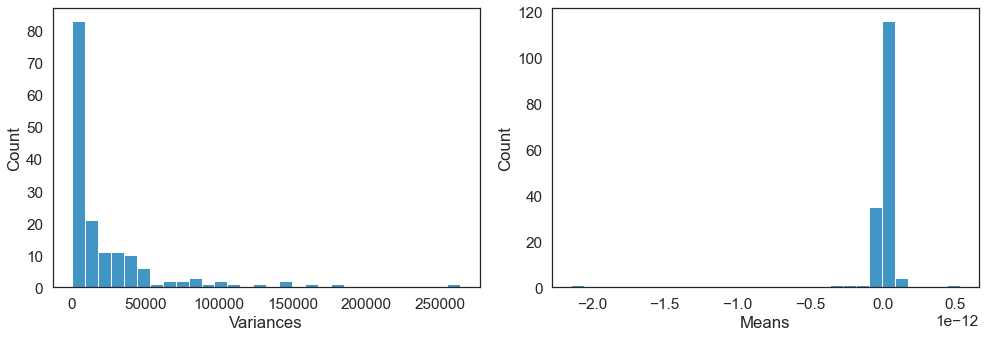

In [39]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
sns.histplot(ax = axs[0], data=Q2_X1.var(), bins=30)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=Q2_X1.mean(), bins=30)
axs[1].set_xlabel('Means')
fig.tight_layout()
plt.show()

In X1, every features is centered on 0 but the variances takes a lot of different values varying from 0 to more than 250000. 

### X2 summary 

In [40]:
Q2_X2.info(max_cols=1)
print(f"Nan values: {Q2_X2.isnull().sum().sum()}")
print(f"Constant features: {Q2_X2.var()[Q2_X2.var() == 0].keys().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Columns: 100 entries, D161 to D260
dtypes: float64(100)
memory usage: 163.4 KB
Nan values: 0
Constant features: 0


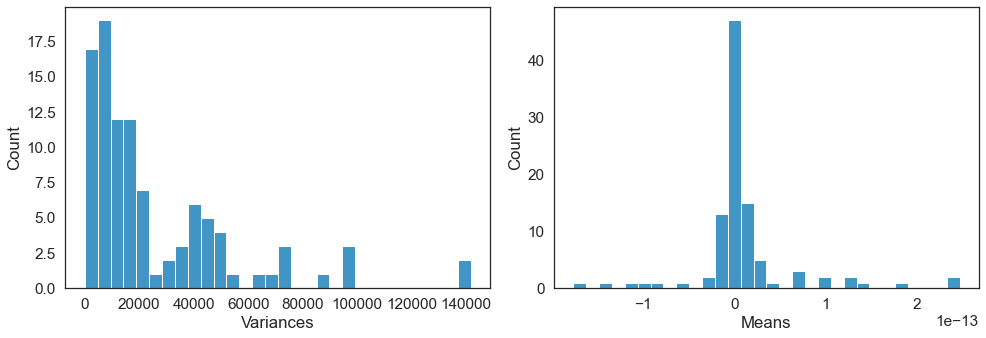

In [41]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
sns.histplot(ax = axs[0], data=Q2_X2.var(), bins=30)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=Q2_X2.mean(), bins=30)
axs[1].set_xlabel('Means')
fig.tight_layout()
plt.show()

In X2, every feature is centered on 0 and the variances take a lot of different values varying from 0 to more than 140000 with most features having its variance between 0 and 50000

Also, note the difference of scale in mean values between X1 and X2: 1e-12 vs 1e-13; this could count in the following.

### (X1, X2) Summary

In [42]:
X_full = pd.concat([Q2_X1, Q2_X2], axis = 1)

In [43]:
X_full.info(max_cols=1)
print(f"Nan values: {X_full.isnull().sum().sum()}")
print(f"Constant features: {X_full.var()[X_full.var() == 0].keys().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Columns: 260 entries, D1 to D260
dtypes: float64(260)
memory usage: 424.7 KB
Nan values: 0
Constant features: 0


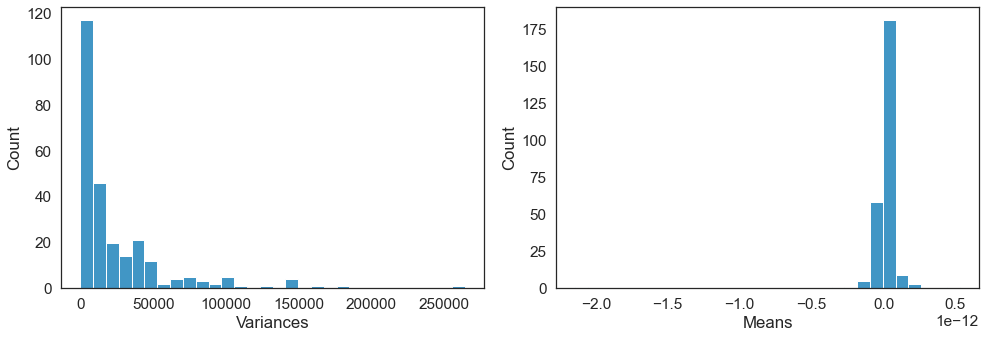

In [44]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
sns.histplot(ax = axs[0], data=X_full.var(), bins=30)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=X_full.mean(), bins=30)
axs[1].set_xlabel('Means')
fig.tight_layout()
plt.show()

No big changes in comparison to X1 except of course for the number of variables on screen, we better Standardize the variables anyway

#### y summary 

In [45]:
Q2_y.info(max_cols=1)
print(f"Nan values: {Q2_y.isnull().sum().sum()}")
print(f"Constant features: {Q2_y.var()[Q2_y.var() == 0].keys().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       209 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
Nan values: 0
Constant features: 0


In [46]:
print(f"Variance: {Q2_y.var()[0]}")
print(f"Mean    : {Q2_y.mean()[0]}")

Variance: 6523.023853432091
Mean    : 338.0862200956939


## The Lasso, $\lambda_{min}$ and $\lambda_{1se}$

The Lasso is as a regression method that encodes variable selection in the form of penalisation. Adding a regularisation term, the $l_1$ norm of the regression coefficients $\beta$, can result in some regression coefficients to be estimated exactly as 0. When coefficients are estimated as zero then the corresponding features do not participate in predicting the response.   Therefore, these features are de-selected.

All non-zero regression coefficients in $\beta$ correspond to features that have been selected.

With the Lasso, optimal prediction quality is achieved when the Mean Scared Error is minimized. Thus the tuning parameter is named $\lambda_{min}$. However, it can be showed that the selection preformed with $\lambda_{min}$ is not particularly great. Too many coefficients are left at small values instead of setting them fully to zero. This improves prediction quality but makes feature selection less valuable.  
To improve feature selection we need to choose a bigger $\lambda$, only a bit larger than $\lambda_{min}$: among all average MSEs (calculated during the cross valdation process to determine $\lambda_{min}$) that are at the most one standard error away from the minimal average MSE, find the largest one and set $\lambda_{1se}$ to the corresponding hyperparameter.  
This way we can keep a decent prediction quality with a better feature selection.

## Feature Selection on X1

In [47]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [48]:
def find_alpha_1se(lasso_fit, n_folds):
    cv_mean = np.mean(lasso_fit.mse_path_, axis=1)
    cv_std = np.std(lasso_fit.mse_path_, axis=1)
    idx_min_mean = np.argmin(cv_mean)
    idx_alpha = np.where(
        (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
        (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
    alpha_1se = lasso_fit.alphas_[idx_alpha]

    return alpha_1se, idx_alpha

### Setup 

In [49]:
random_state = np.random.default_rng(12345)
n_bootstraps = 100
n_folds      = 10
lasso_tol    = 1e-3
max_iter     = 1000 

n = Q2_X1.shape[0]
p = Q2_X1.shape[1]

alpha_1se = np.zeros(n_bootstraps, dtype=float)
coef_1se  = np.zeros((n_bootstraps, p), dtype=float)

### Process 

In [50]:
for iteration in range(n_bootstraps):
    idx = random_state.choice(n, n, replace=True)
    X = Q2_X1.to_numpy()[idx, :]
    y = Q2_y.to_numpy()[idx]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lasso_cv = LassoCV(cv=n_folds, tol=lasso_tol, max_iter=max_iter)
    lasso_cv.fit(X_scaled, y[:,0])

    alpha_1se[iteration], _ = find_alpha_1se(lasso_cv, n_folds)
    
    lasso_1se = Lasso(
        alpha=alpha_1se[iteration], tol=lasso_tol, max_iter=max_iter
    ).fit(X_scaled, y)
    
    coef_1se[iteration]  = lasso_1se.coef_

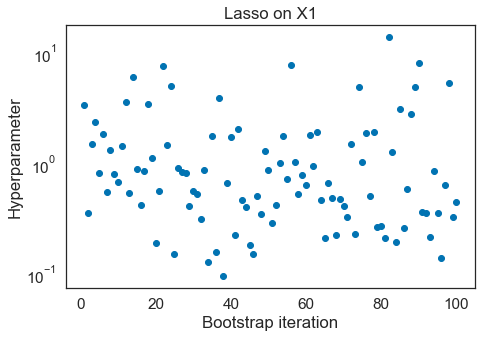

In [51]:
plt.figure(figsize = (7, 5))
plt.scatter(range(1, n_bootstraps + 1), alpha_1se)
plt.title('Lasso on X1')
plt.xlabel('Bootstrap iteration')
plt.yscale('log')
plt.ylabel('Hyperparameter')
plt.tight_layout()

When investigating hyperparameter, it is visible that this study has relatively random hyperparameter selections, suggesting either that penalization does not have a beneficial effect here, or the shapes are not very clearly defined and they vary substantially from bootstrap run to bootstrap run.  

In [52]:
coef_1se_freq = np.mean(
    (np.abs(coef_1se) >= 1e-8).astype(int), 
    axis=0
)
coef_1se_median = np.median(coef_1se, axis=0)
C = (1.25/1.35)/np.sqrt(n_bootstraps)
coef_1se_median_error = C * np.subtract.reduce(np.percentile(coef_1se, [75, 25], axis=0))

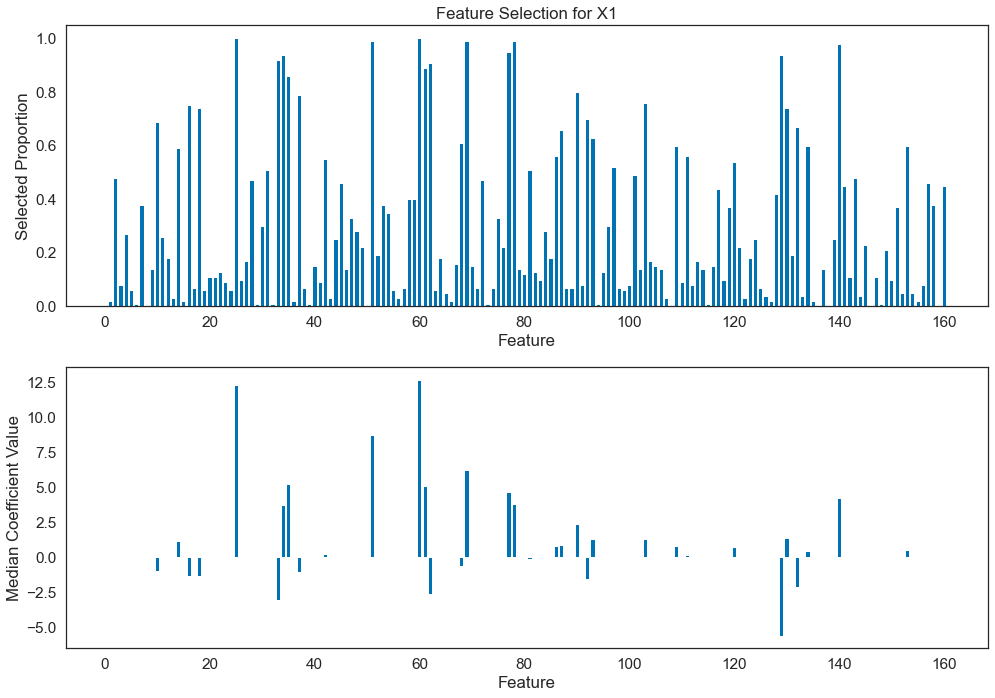

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.bar(range(1, p+1), coef_1se_freq)
ax1.set_xlabel("Feature")
ax1.set_ylabel("Selected Proportion")
ax1.set_title("Feature Selection for X1")

ax2.bar(range(1, p+1), coef_1se_median)
ax2.set_xlabel("Feature")
ax2.set_ylabel("Median Coefficient Value")

fig.tight_layout()
plt.show()

In [54]:
top = 20

In [55]:
coef_1se_freq_most_idx = np.argsort(coef_1se_freq)[::-1][:top]
coef_1se_freq_most = coef_1se_freq[coef_1se_freq_most_idx]
coef_1se_freq_most_median = coef_1se_median[coef_1se_freq_most_idx]
coef_1se_freq_most_median_error = coef_1se_median_error[coef_1se_freq_most_idx]

In [56]:
df_1se = pd.concat(
    [
        pd.DataFrame({'idx': Q2_X1.columns[coef_1se_freq_most_idx]}), 
        pd.DataFrame({'frequency': coef_1se_freq_most}), 
        pd.DataFrame({'median': coef_1se_freq_most_median}), 
        pd.DataFrame({'abs_median': np.abs(coef_1se_freq_most_median)}),
        pd.DataFrame({'median error': coef_1se_freq_most_median_error})

    ], 
    axis = 1
)

df_1se = df_1se.sort_values(['frequency', 'abs_median'], ascending=[False, False])

# Get the good order
df_1se = df_1se.reindex(['idx', 'frequency', 'median', 'median error'], axis=1)
# Continuous row indices
df_1se = df_1se.reset_index(drop=True)

In [57]:
df_1se

,idx,frequency,median,median error
0,D60,1.00,12.653575,0.741935
1,D25,1.00,12.293113,0.506807
2,D51,0.99,8.695985,0.311970
3,D69,0.99,6.212091,0.251401
4,D78,0.99,3.818764,0.250837
5,D140,0.98,4.201569,0.189835
6,D77,0.95,4.630202,0.308399
7,D129,0.94,-5.584838,0.603293
8,D34,0.94,3.745190,0.247529
9,D33,0.92,-3.031430,0.300761


## Feature Selection on (X1, X2)

### Setup 

In [58]:
random_state = np.random.default_rng(12345)
n_bootstraps = 100
n_folds      = 10
lasso_tol    = 1e-3
max_iter     = 1000 
 
n = X_full.shape[0]
p = X_full.shape[1]

alpha_1se_full = np.zeros(n_bootstraps, dtype=float)
coef_1se_full  = np.zeros((n_bootstraps, p), dtype=float)

In [59]:
for iteration in range(n_bootstraps):
    idx = random_state.choice(n, n, replace=True)
    X = X_full.to_numpy()[idx, :]
    y = Q2_y.to_numpy()[idx]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lasso_cv = LassoCV(cv=n_folds, tol=lasso_tol, max_iter=max_iter)
    lasso_cv.fit(X_scaled, y[:,0])

    alpha_1se_full[iteration], _ = find_alpha_1se(lasso_cv, n_folds)
    
    lasso_1se = Lasso(
        alpha=alpha_1se_full[iteration], tol=lasso_tol, max_iter=max_iter
    ).fit(X_scaled, y)
    
    coef_1se_full[iteration] = lasso_1se.coef_

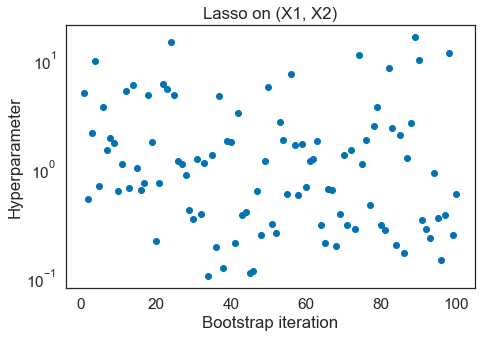

In [60]:
plt.figure(figsize = (7, 5))
plt.scatter(range(1, n_bootstraps + 1), alpha_1se_full)
plt.title('Lasso on (X1, X2)')
plt.xlabel('Bootstrap iteration')
plt.yscale('log')
plt.ylabel('Hyperparameter')
plt.tight_layout()

When investigating hyperparameter, it is visible that this study has relatively random hyperparameter selections, suggesting either that penalisation does not have a beneficial efect here, or the shapes are not very clearly defiend and they vary substancially from bootstrap run to bootstrap run.

In [61]:
coef_1se_full_freq = np.mean(
    (np.abs(coef_1se_full) >= 1e-8).astype(int), 
    axis=0
)
coef_1se_full_median = np.median(coef_1se_full, axis=0)
C = (1.25/1.35)/np.sqrt(n_bootstraps)
coef_1se_full_median_error = C * np.subtract.reduce(np.percentile(coef_1se_full, [75, 25], axis=0))

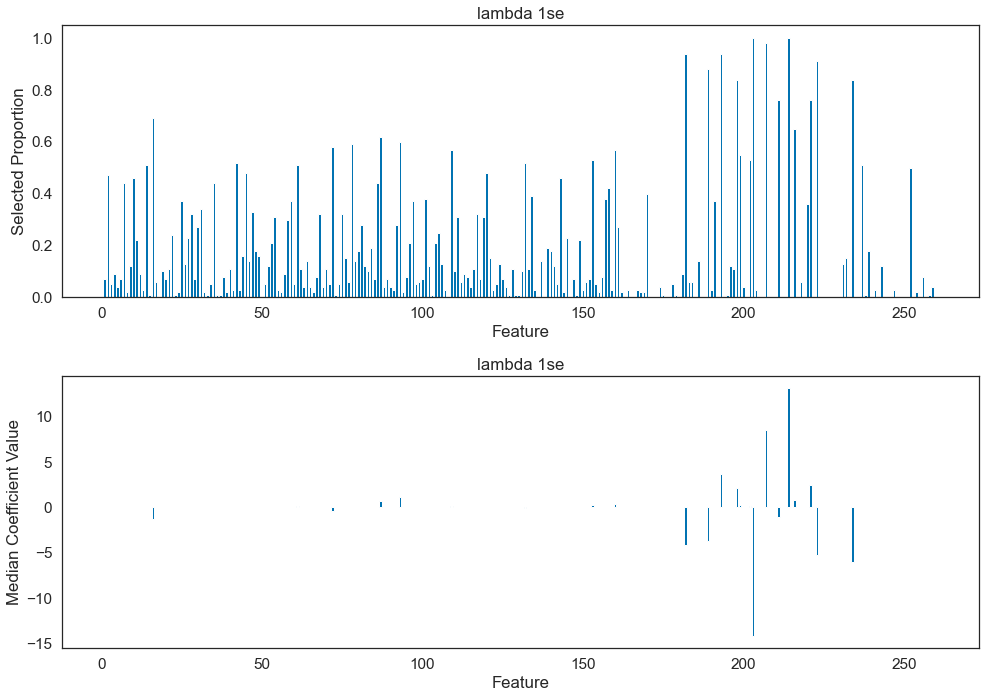

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.bar(range(1, p+1), coef_1se_full_freq)
ax1.set_xlabel("Feature")
ax1.set_ylabel("Selected Proportion")
ax1.set_title("lambda 1se")

ax2.bar(range(1, p+1), coef_1se_full_median)
ax2.set_xlabel("Feature")
ax2.set_ylabel("Median Coefficient Value")
ax2.set_title("lambda 1se")

fig.tight_layout()
plt.show()

In [63]:
top = 20

In [64]:
coef_1se_full_freq_most_idx = np.argsort(coef_1se_full_freq)[::-1][:top]
coef_1se_full_freq_most = coef_1se_full_freq[coef_1se_full_freq_most_idx]
coef_1se_full_freq_most_median = coef_1se_full_median[coef_1se_full_freq_most_idx]
coef_1se_full_freq_most_median_error = coef_1se_full_median_error[coef_1se_full_freq_most_idx]

In [65]:
df_1se_full = pd.concat(
    [
        pd.DataFrame({'idx': X_full.columns[coef_1se_full_freq_most_idx]}), 
        pd.DataFrame({'frequency': coef_1se_full_freq_most}), 
        pd.DataFrame({'median': coef_1se_full_freq_most_median}), 
        pd.DataFrame({'abs_median': np.abs(coef_1se_full_freq_most_median)}), 
        pd.DataFrame({'median error': coef_1se_full_freq_most_median_error})

    ], 
    axis = 1
)

df_1se_full = df_1se_full.sort_values(['frequency', 'abs_median'], ascending=[False, False])

# Get the good order
df_1se_full = df_1se_full.reindex(['idx', 'frequency', 'median', 'median error'], axis=1)
# Continuous row indices
df_1se_full = df_1se_full.reset_index(drop=True)

In [66]:
df_1se_full

,idx,frequency,median,median error
0,D203,1.00,-14.194068,0.619458
1,D214,1.00,13.132429,0.635631
2,D207,0.98,8.558914,0.445840
3,D182,0.94,-4.124997,0.287674
4,D193,0.94,3.697720,0.263358
5,D223,0.91,-5.293464,0.614057
6,D189,0.88,-3.769081,0.298513
7,D234,0.84,-6.079917,0.679858
8,D198,0.84,2.160394,0.198957
9,D221,0.76,2.460448,0.406200


## Recap 

In [67]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

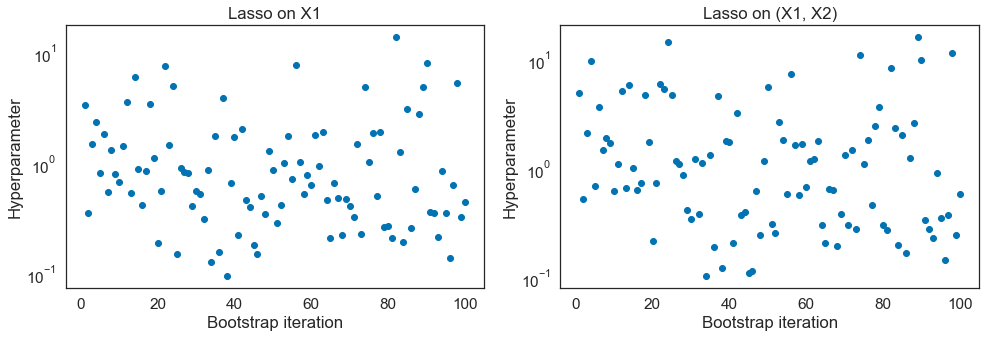

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(range(1, n_bootstraps + 1), alpha_1se)
ax1.set_title('Lasso on X1')
ax1.set_xlabel('Bootstrap iteration')
ax1.set_yscale('log')
ax1.set_ylabel('Hyperparameter')

ax2.scatter(range(1, n_bootstraps + 1), alpha_1se_full)
ax2.set_title('Lasso on (X1, X2)')
ax2.set_xlabel('Bootstrap iteration')
ax2.set_yscale('log')
ax2.set_ylabel('Hyperparameter')
plt.tight_layout()

In both cases, when investigating hyperparameter, it is visible that this study has relatively random hyperparameter selections, suggesting either that penalisation does not have a beneficial efect here, or the shapes are not very clearly defiend and they vary substancially from bootstrap run to bootstrap run.

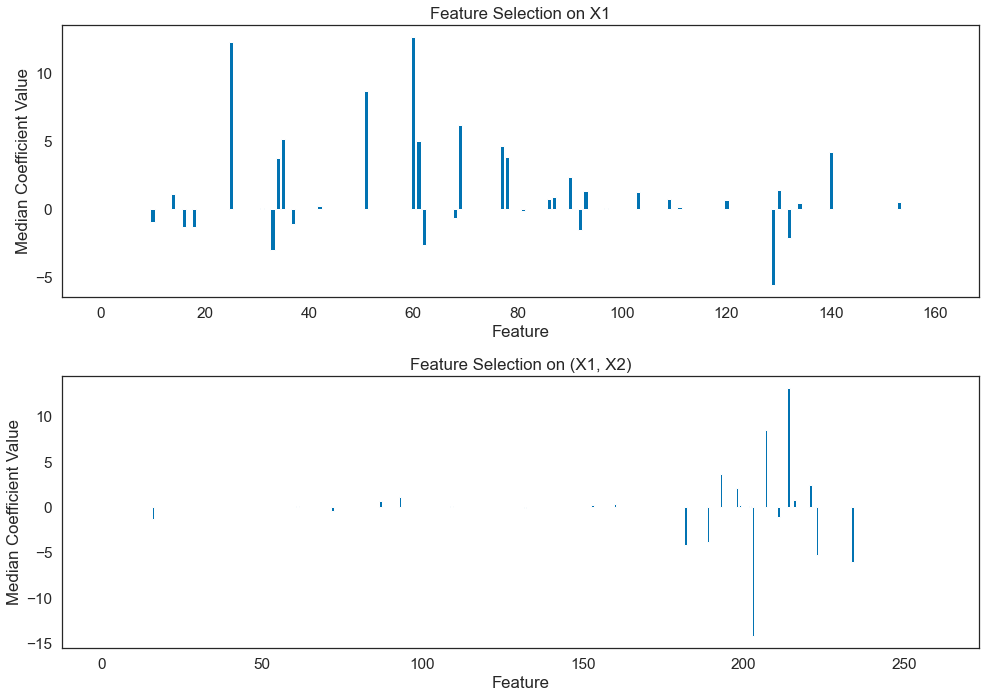

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.bar(range(1, Q2_X1.shape[1]+1), coef_1se_median)
ax1.set_xlabel("Feature")
ax1.set_ylabel("Median Coefficient Value")
ax1.set_title("Feature Selection on X1")

ax2.bar(range(1, p+1), coef_1se_full_median)
ax2.set_xlabel("Feature")
ax2.set_ylabel("Median Coefficient Value")
ax2.set_title("Feature Selection on (X1, X2)")

fig.tight_layout()
plt.show()

In [70]:
display_side_by_side([df_1se, df_1se_full], ['Feature Selection on X1', 'Feature Selection on (X1, X2)'])

,idx,frequency,median,median error
0,D60,1.000000,12.653575,0.741935
1,D25,1.000000,12.293113,0.506807
2,D51,0.990000,8.695985,0.311970
3,D69,0.990000,6.212091,0.251401
4,D78,0.990000,3.818764,0.250837
5,D140,0.980000,4.201569,0.189835
6,D77,0.950000,4.630202,0.308399
7,D129,0.940000,-5.584838,0.603293
8,D34,0.940000,3.745190,0.247529
9,D33,0.920000,-3.031430,0.300761


Here it is very clear that most of features from X1 have not been selected

## Correlations Study

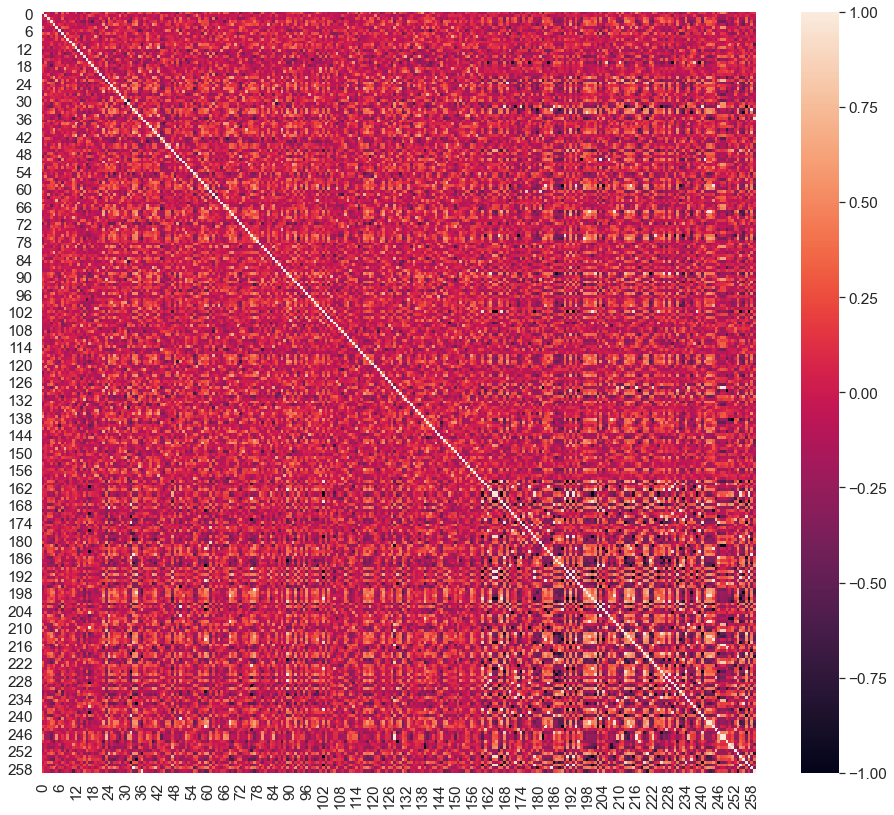

In [71]:
plt.figure(figsize=(16, 14))
sns.heatmap(np.corrcoef(X_full.T), vmin=-1, vmax=1)
plt.show()

Correlation matrix of (X1, X2). The first 160 features come from X1, the following features come from X2. 

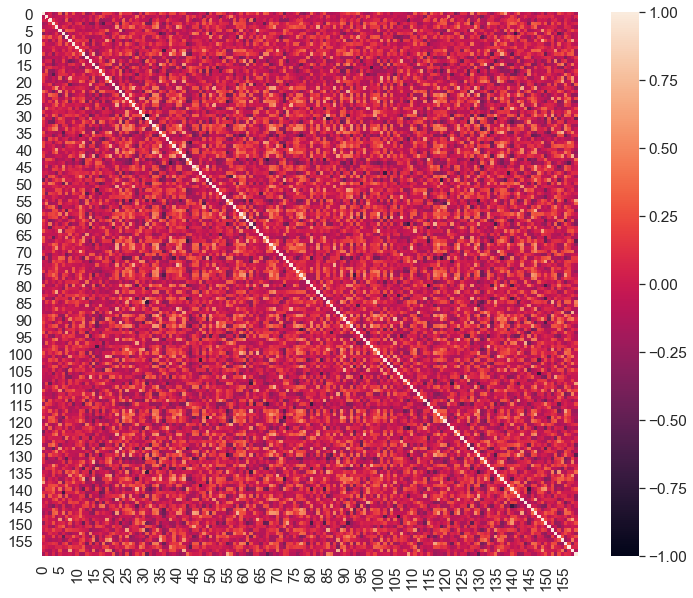

In [72]:
plt.figure(figsize=(12, 10))
sns.heatmap(np.corrcoef(Q2_X1.T), vmin=-1, vmax=1)
plt.show()

No specific correlation between features

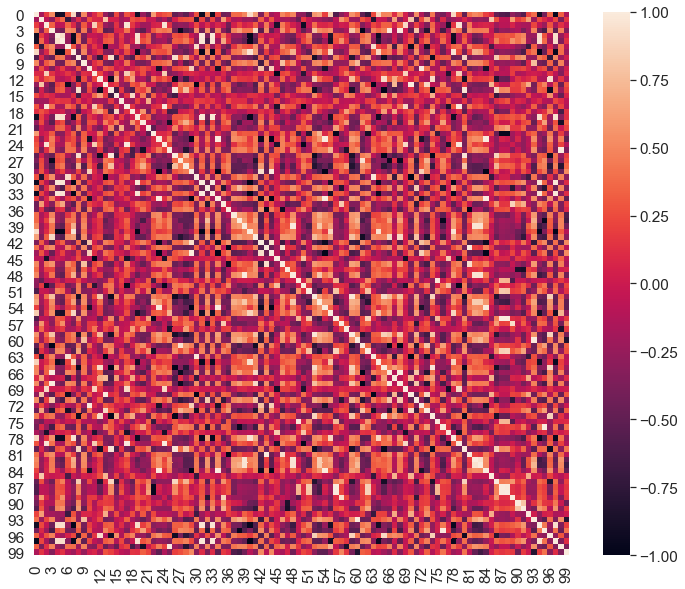

In [73]:
plt.figure(figsize=(12, 10))
sns.heatmap(np.corrcoef(Q2_X2.T), vmin=-1, vmax=1)
plt.show()

A lot of features correlate we each other (positively and negatively)

# Question 3

## Data Simulation

In [74]:
from sklearn.datasets import make_classification

make_classification generates a random n-class classification problem.  

This initially creates clusters of points normally distributed (std=1) about vertices of an n_informative-dimensional hypercube with sides of length 2*class_sep and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data.  
  
Without shuffling, X horizontally stacks features in the following order: the primary n_informative features, followed by n_redundant linear combinations of the informative features, followed by n_repeated duplicates, drawn randomly with replacement from the informative and redundant features. The remaining features are filled with random noise. Thus, without shuffling, all useful features are contained in the columns X[:, :n_informative + n_redundant + n_repeated].

In [75]:
X_simul, y_simul = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_repeated = 1, 
    n_classes = 2,
    random_state = 12345
)

In [76]:
y_simul.shape

(1000,)

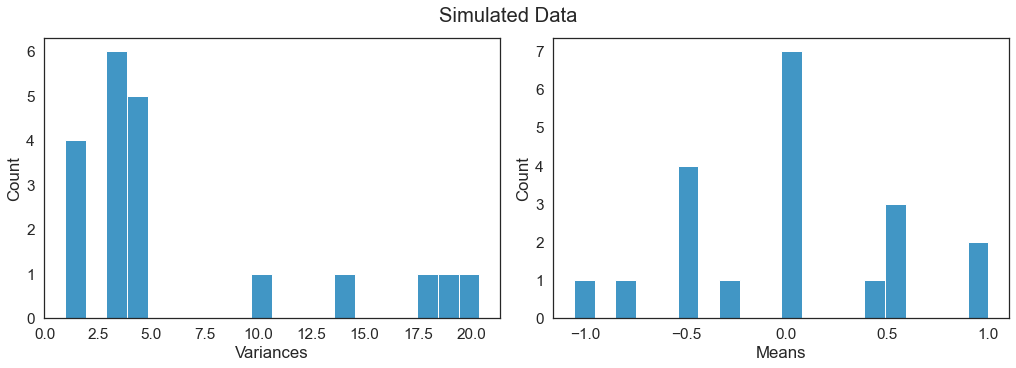

In [77]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5), constrained_layout=True)
sns.histplot(ax = axs[0], data=X_simul.var(axis=0), bins=20)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=X_simul.mean(axis=0), bins=20)
axs[1].set_xlabel('Means')

fig.suptitle('Simulated Data')

plt.show()

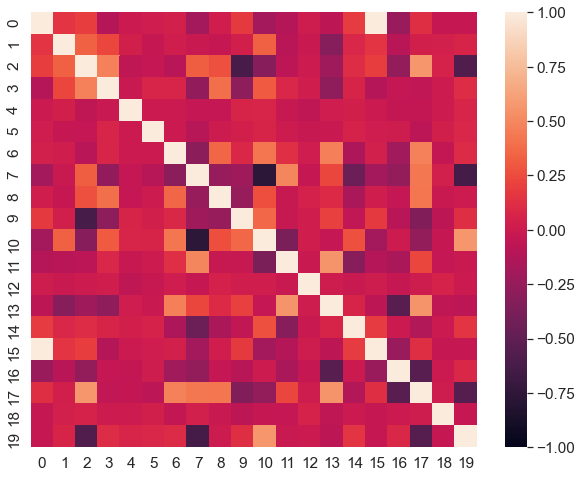

In [78]:
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(X_simul.T), vmin=-1, vmax=1)
plt.show()

## Mislabelling function and predict ground truth algorithm 

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [80]:
def mislabelling(y, p, rng=np.random.default_rng()): 
    n = y.shape[0]
    mislabel_idx = rng.choice(n, size=int(p * n), replace=False)
    y_mislabel = y.copy() # deep copy
    y_mislabel[mislabel_idx] = (y_mislabel[mislabel_idx] - 1)*(-1)
    return y_mislabel

In [87]:
def predict_ground_truth(X, y, boundary=0.5): #Returns prediction of what should have been the initial y
    rf = RandomForestClassifier(oob_score=True, n_jobs=-1).fit(X,y)
    noise_prob = 1 - rf.oob_decision_function_[range(len(y)),y]
    mislabel_idx = np.argwhere(noise_prob > boundary)# .reshape(-1)
    
    y_predict = y.copy()
    y_predict[mislabel_idx] = (y_predict[mislabel_idx] - 1)*(-1) 
    return y_predict

## Running the algorithm

### Setup 

In [90]:
flip_proba = np.arange(0.05, 0.11, 0.01)
boundaries = np.arange(0.40, 1.2, 0.02)
repeats    = 5

### Process

Since we want to maximises true positives and minimises false positives, we basically want to maximize Receiver Operating Characteristic (ROC) and therefore to maximize the Area under the ROC curve (AUC).

End of iteration 1/5
End of iteration 2/5
End of iteration 3/5
End of iteration 4/5
End of iteration 5/5


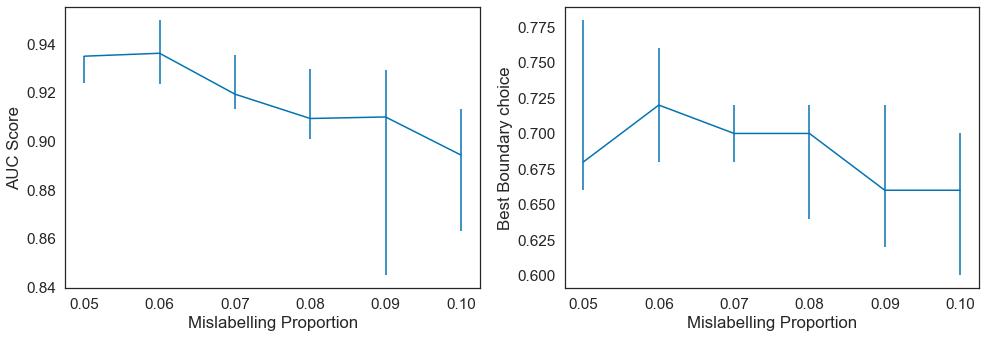

In [91]:
auc           = np.zeros((len(flip_proba), repeats), dtype=float)
best_boundary = np.zeros((len(flip_proba), repeats), dtype=float)

scores_buffer = np.zeros((len(boundaries), ), dtype=float)


for repeat in range(repeats):
    X_train, X_test, y_train, y_test = train_test_split(X_simul, y_simul, test_size=0.2)
    
    for i, p in enumerate(flip_proba):
        
        y_mislabel = mislabelling(y_train, p)

        
        for j, boundary in enumerate(boundaries) :
            y_predict = predict_ground_truth(X_train, y_mislabel, boundary=boundary)
            scores_buffer[j] = roc_auc_score(y_train, y_predict)

        best_boundary[i, repeat] = boundaries[np.argmax(scores_buffer)]
        auc[i, repeat] = roc_auc_score( # estimates test score
            y_test, 
            predict_ground_truth(X_test, mislabelling(y_test, p), boundary=best_boundary[i, repeat])
        )
    print(f"End of iteration {repeat+1}/{repeats}")
        
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

ax1.errorbar(
    flip_proba, 
    np.median(auc, axis=1), 
    [
        np.median(auc, axis=1) - np.min(auc, axis=1), 
        np.max(auc, axis=1) - np.median(auc, axis=1)
    ]
)
ax1.set_xlabel("Mislabelling Proportion")
ax1.set_ylabel("AUC Score")

ax2.errorbar(
    flip_proba, 
    np.median(best_boundary, axis=1), 
    [
        np.median(best_boundary, axis=1) - np.min(best_boundary, axis=1), 
        np.max(best_boundary, axis=1) - np.median(best_boundary, axis=1)
    ]
)

ax2.set_xlabel("Mislabelling Proportion")
ax2.set_ylabel("Best Boundary choice")

plt.tight_layout()

## Provided Dataset exploration

In [92]:
Q3_X = pd.read_csv('./data/Q3_X.csv', index_col=None)
Q3_labels_mislabelled = pd.read_csv('./data/Q3_labels_mislabelled.csv', index_col=None)
Q3_labels_correct = pd.read_csv('./data/Q3_labels_correct.csv', index_col=None)

In [93]:
Q3_X.info(max_cols=1)
print(f"Nan values: {Q3_X.isnull().sum().sum()}")
print(f"Constant features: {Q3_X.var()[Q3_X.var() == 0].keys().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Columns: 54 entries, X1 to X54
dtypes: float64(54)
memory usage: 1.6 MB
Nan values: 0
Constant features: 0


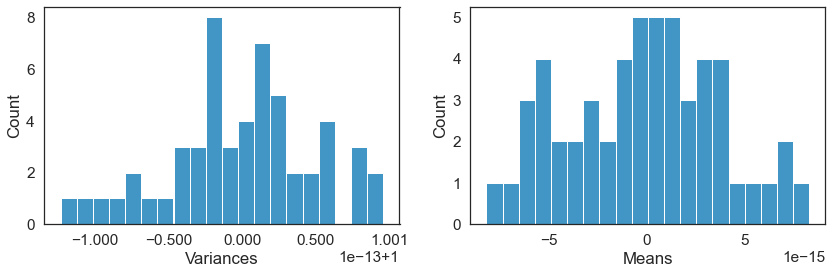

In [94]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
sns.histplot(ax = axs[0], data=Q3_X.var(), bins=20)
axs[0].set_xlabel('Variances')

sns.histplot(ax = axs[1], data=Q3_X.mean(), bins=20)
axs[1].set_xlabel('Means')
plt.show()

These are standardized featured (mean = 0, var = 1)

In [95]:
Q3_labels_mislabelled.value_counts()

label
0        2127
1        1774
dtype: int64

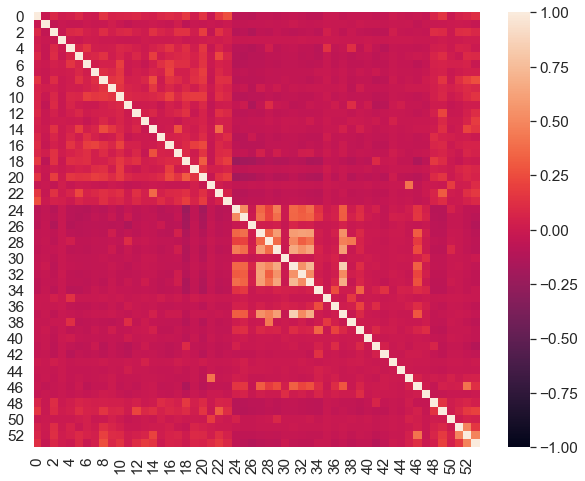

In [96]:
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(Q3_X.T), vmin=-1, vmax=1)
plt.show()

 ## Application to the provided dataset 

In [97]:
boundary_last = 0.675

In [98]:
y_predict = predict_ground_truth(Q3_X, Q3_labels_mislabelled.to_numpy()[:, 0], boundary=boundary_last)
auc_score = roc_auc_score(Q3_labels_correct.to_numpy()[:, 0], y_predict)
print(f"Auc score = { auc_score }")
print(f"error rate = { 1 - auc_score }")

Auc score = 0.9648351443684081
error rate = 0.035164855631591885


In [102]:
confMat = pd.DataFrame(confusion_matrix(Q3_labels_correct.to_numpy()[:, 0], y_predict))
confMat.index = ['positve', 'negative']
confMat.columns = ['positive', 'negative']
confMat

,positive,negative
positve,2115,50
negative,82,1654


In [103]:
target_names = ['class 0', 'class 1']
print(classification_report(Q3_labels_correct.to_numpy()[:, 0], y_predict, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      2165
     class 1       0.97      0.95      0.96      1736

    accuracy                           0.97      3901
   macro avg       0.97      0.96      0.97      3901
weighted avg       0.97      0.97      0.97      3901

